***TRAINING CONVOLUTIONAL NEURAL NETWORK FOR IMAGE CLASSIFICATION ***

this classification model is created using PyTorch machine learning library, A pre-trained deep neural network which was based on the ResNet18 architecture was finetuned. After 24 epochs, the model reaches an accuracy of 96% on the test data which represents 20% of the overall data set.


In [2]:
%matplotlib inline
!git clone https://gitlab.com/omar.nwt/spacetask.git
#uncomment previous line to import structured data

Cloning into 'spacetask'...
remote: Enumerating objects: 27050, done.
remote: Counting objects: 100% (27050/27050), done.
remote: Compressing objects: 100% (27048/27048), done.
remote: Total 27050 (delta 1), reused 27036 (delta 0)
Receiving objects: 100% (27050/27050), 165.09 MiB | 12.63 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (27008/27008), done.


In [0]:
from __future__ import print_function,division

import torch
import torchvision  
import torchvision.transforms as tranys
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import models,datasets
from torch.optim import lr_scheduler 
import time
import os
import copy

**Load Data**

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': tranys.Compose([
        tranys.RandomResizedCrop(224),
        tranys.RandomHorizontalFlip(),
     #   tranys.ColorJitter(),
        tranys.ToTensor(),
        tranys.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    'val': tranys.Compose([
        tranys.Resize(256),
        tranys.CenterCrop(224),
        tranys.ToTensor(),
        tranys.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    'test': tranys.Compose([
        tranys.Resize(256),
        tranys.CenterCrop(224),
        tranys.ToTensor(),
        tranys.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
}
master_f = './spacetask/data'
image_datasets = {x: datasets.ImageFolder(os.path.join(master_f,x),
                                          data_transforms[x])
                 for x in ['train','val','test']}
data_loaders={x: torch.utils.data.DataLoader(image_datasets[x],batch_size=4
                                             ,shuffle=True, num_workers=4) 
                 for x in ['train','val','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val','test']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Visualizing few images**

checking the data augmentations.

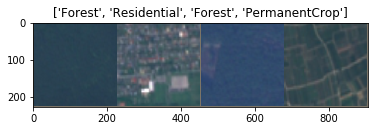

In [5]:
def imshow(img, title=None):
    img=img.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img*std+mean
    img = np.clip(img, 0 ,1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(data_loaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
        

**Training the model**

two very important points:


*   Scheduling the learning rate
*   Saving the best model




In [0]:
def train_model(model, criterion, optimizer, scheduler,num_epochs=4):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss_values_train = []
    
    for epoch in range(num_epochs):
        print('Epoch{}/{}'.format(epoch, num_epochs - 1))
        print('-'*10)
        

        # Each epoch has a training and validation phase
        for phase in ['train','val']:
            if phase =='train':
                model.train()# Set model to training mode
            else:
                model.eval()
                    
            running_loss = 0.0 
            running_corrects= 0
            
            
            # Iterate over data.
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs,labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
                loss_values_train.append(running_loss / len(image_datasets["train"]))
        
            epoch_loss =  running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
    
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss,epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
               
                
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60 ))
    print('best val acc: {:4f}'.format(best_acc))
    plt.plot(np.array(loss_values_train), 'r')
    
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

**Visualizing the model predictions**

In [0]:
#Generic function to display predictions for a few images
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

**Finetuning the CNN**

Loading a pretrained model and reseting final fully connected layer

In [0]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs,10)# Here the size of each output sample is set to 10.
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(),lr=0.0005,momentum=0.9)
#optimizer_ft = optim.RMSprop(model_ft.parameters(),lr=0.001)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7 , gamma=0.1)

**Training and evaluating model**

In [0]:
model_ft = train_model(model_ft,criterion,optimizer_ft,exp_lr_scheduler,num_epochs=2)

Epoch0/1
----------


In [0]:
visualize_model(model_ft)

Test the network on the test data

In [19]:
correct = 0
total = 0
with torch.no_grad():
    for data in data_loaders['test']:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 90 %


**Saving the model in pt format**

In [0]:
torch.save(model_ft.state_dict(), "./model30epoch.pt")
from google.colab import files
files.download("./model30epoch.pt") 

**performing inference**

In [0]:
#performing inference
#all you have to do is give image path and model path
!./inference.py --img_path ./data/test/River/2004.jpg --mod_path ./models/model24epoch.pt